# Deep Reinforcement Learning Assignment

This assignment should be done in groups of 2 or 3 (preferably 3).

This assignment consists of two parts. In the first part, your task is to solve a grid world environment using the REINFORCE algorithm. In the second part, your task is to balance a pendulum attached to a cart such that it stays upright. You will implement the A2C algorithm that will learn a control policy for the cart.

## Imports 
Imports required packages. Add additional packages if needed.

In [1]:
import gymnasium as gym
import numpy as np
import random
import torch

import tqdm

import matplotlib.pyplot as plt
from matplotlib.table import Table

# Part 1: GridWorld with REINFORCE (9 pts)
Firstly, you will implement REINFORCE in the GridWorld environment. The agent starts from the center, and the four actions left, right, up and down move the agent in the appropriate directions deterministically. The corner states are terminal and have the corresponding rewards.

**In this part, you should only use `numpy` operations (i.e., no automated differentiation with PyTorch).**

### The GridWorld Environment

We already provide a basic implementation of the grid world environment which you will use,
as well as the constants `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`.
You do not need to modify the class `GridWorld`.

In [2]:
#DO NOT MOIFY
ACTION_LEFT = 0
ACTION_RIGHT = 1
ACTION_UP = 2
ACTION_DOWN = 3

def clip(x, a, b):
    if x < a:
        return a
    if x > b:
        return b
    
    return x

class GridWorld:
    
    def __init__(self, size=3):
        self.size = size
        self.state = [0,0]
        self.actions = [ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN]
        
    def reset_world(self):
        self.state = [0,0]
    
    def is_terminal(self):
        return abs(self.state[0]) == self.size and abs(self.state[1]) == self.size
    
    def get_current_reward(self):
        if self.state == [self.size, self.size] or \
           self.state == [-self.size, -self.size]:
            return -1
        elif self.state == [-self.size, self.size] or \
             self.state == [self.size, -self.size]:
            return +1
        else:
            return 0
        
    def list_actions(self):
        return self.actions
    
    def step(self, action):
        if action not in self.actions:
            raise NotImplementedError("Action not defined")
            
        if self.is_terminal():
            raise NotImplementedError("Epsiode terminated! Call reset_world first.")

        if action == ACTION_LEFT:
            self.state[0] = clip(self.state[0]-1, -self.size, self.size)
            
        elif action == ACTION_RIGHT:
            self.state[0] = clip(self.state[0]+1, -self.size, self.size)
            
        elif action == ACTION_UP:
            self.state[1] = clip(self.state[1]+1, -self.size, self.size)
            
        elif action == ACTION_DOWN:
            self.state[1] = clip(self.state[1]-1, -self.size, self.size)
        
    def get_coordinates(self):
        s = np.array(self.state)
        s[0] = s[0] + self.size
        s[1] = self.size - s[1]
        
        return s
    
    def get_state(self):
        return self.get_coordinates()[0] + \
               self.get_coordinates()[1] * (self.size * 2 + 1)
    
    def render_state(self):
        N = self.size
        x = self.state[0]
        y = self.state[1]

        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_axis_off()

        tb = Table(ax, bbox=[0,0, 1, 1])

        row_labels = np.arange(2 * N + 1)
        col_labels = np.arange(2 * N + 1)
        width, height = .5, .5

        values = np.zeros((N*2+1, N*2+1))
        values[0,0] = values[-1, -1] = 1
        values[-1,0] = values[0, -1] = -1

        cell_colors = ('white', 'whitesmoke')
        font_colors = ('black', 'white')

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            if cell_val !=  0.:
                text = "%.1f" % cell_val
                if cell_val > 0:
                    c = "lightblue"
                else:
                    c = "lightcoral"
            elif row_idx == N and col_idx == N:
                text = "start"
                c = "antiquewhite"
            else:
                text = ""
                c = cell_colors[idx]

            tb.add_cell(row_idx, col_idx, width, height,
                        text=text,
                        loc='center',
                        facecolor=c)

        for (row_idx, col_idx), cell_val in np.ndenumerate(values):
            idx = (col_idx + row_idx) % 2
            tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[idx])

        pos = plt.Circle((0.5 + 1/(2 * N + 1) * x, 0.5 + 1/(2 * N + 1) * y + .04), 0.01, color='black')
        ax.add_patch(pos)
        ax.add_table(tb)

You can plot the environment with `render_state()`

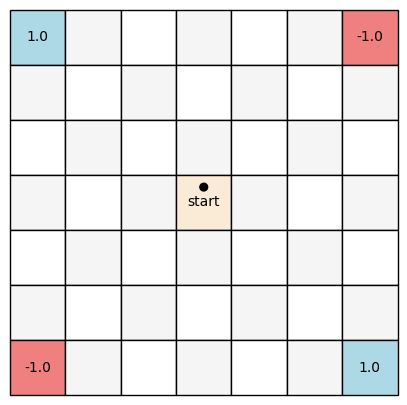

In [3]:
GridWorld().render_state()

The state after the agent takes the action `ACTION_RIGHT`

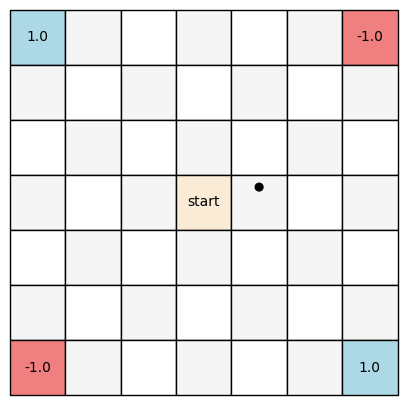

In [4]:
world = GridWorld()
world.reset_world()
world.step(ACTION_RIGHT)
world.render_state()

Cells/states are numbered from 0 to 48, left to right, top to bottom

In [5]:
world.get_state()

25

For convenience, cells are given coordinates left to right, top to bottom

In [6]:
world.get_coordinates()

array([4, 3])

### Direct Parameterization


In this part, we will define the policy according to an exponential softmax distribution where action preferences are linear using feature vectors \phi_{s,a}:
$$
\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_{a'} {\exp{\theta^\top \phi_{s,a'}}}}
$$

We will assume that the vectors $\phi_{s,a} \in \mathbb{R}^{|\mathcal{S}||\mathcal{A}|}$ are encoded as standard unit basis vectors (i.e., one-hot encoding).
First, we will create an appropriate encoding function for the states in GridWorld.

For consistency, we assume the actions are mapped to integers with `ACTION_LEFT=0, ACTION_RIGHT=1, ACTION_UP=2, ACTION_DOWN=3`, and the cell states are given values from 0 to 48, starting from left to right, from the top row to the bottom row. 
Note that `GridWorld.get_state()` implements the correct order on grid cells.
$\phi_{s,a}$ is assumed to be the unit vector with only the entry at position $4\times s + a$ equal to 1.





**Task 1.1 (0.5 pt):** Create a function `get_features_onehot` that encodes each $\phi_{s,a}$ with a one hot encoded vector in $\mathbb{R}^{|\mathcal{S}||\mathcal{A}|} = \mathbb{R}^{196}$ as a numpy vector.

In [63]:
def get_features_onehot(state:int, action:int):
    """Given the tuple (x,y) indicating the coordinates on the grid world, return one hot encoded features
    
    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """
    
    # TODO: FILL IN YOUR CODE HERE!
    array = np.zeros(49*4)
    array[4*state+action]=1
    return array
    # pass

print(get_features_onehot(1,1))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


**Task 1.2 (0.5 pt):** Implement an initialisation for the parameters $\theta \in \mathbb{R}^{196}$ as a numpy vector that you think is appropriate for efficient exploration.

In [44]:
def get_initial_parameters(inital_dis):
    """Returns vector of size 196 of initial parameters theta"""
    
    # TODO: FILL IN YOUR CODE HERE!
    array = np.zeros(49*4)
    single_value = np.random.uniform(0,1)
    for i in range(0,49*4,4):
        for j in range(0,4):
            if inital_dis == 'Gaussian Low variance':
                array[i+j]=np.random.normal(0,0.01) 
            elif inital_dis == 'uniform':
                array[i+j] = np.random.uniform(0,1)
            elif inital_dis == 'Gaussian High variance':
                array[i+j] == np.random.normal(0,100)

    return array

print(get_initial_parameters('normal').shape)
# print(get_initial_parameters())

(196,)


**Task 1.3 (2 pts):** 
Calculate the partial derivatives $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$.
First, write down the analytic formula for the derivative *in the Markdown cell below (use LaTeX-math mode for equations, etc.).* Show your computation steps! 


Then, using your expression fill in `direct_parameterisation_derivative`, that will return the vector $\frac{\partial \pi_\theta(a|s)}{\partial \theta}$ given a value of $\theta$ and action-state pair $a,s$.

**Hint:** For the analytic part, you may write down the formula for $\frac{\partial \pi_\theta(a|s)}{\partial \theta_{a',s'}}$, i.e., the partial derivative with respect to the entry of $\theta$ corresponding to any action-state pair $a', s'$.

**Hint:** The function `direct_parameterisation_derivative` should return a vector of size $4 |S| = 4 \times 7^2=196$, since you have 4 actions and $7^2$ states.


**Hint:** Only 4 entries of $\frac{\partial \pi_\theta(a|s)}{\partial \theta} \in \mathbb{R}^{196}$ should be nonzero for fixed $a,s$.

$$
\pi_\theta(a|s) = \frac{\exp{\theta^\top \phi_{s,a}}}{\sum_{a'} {\exp{\theta^\top \phi_{s,a'}}}}
$$

Given the one hot representation, $\theta^T$ $\phi_{s,a}$ becomes $\theta_{s,a}$. Then the above equation can be rewritten as 

$$
\pi_\theta(a|s) = \frac{\exp{\theta_{s,a}}}{\sum_{a'} {\exp{\theta_{s,a'}}}}
$$

Differebtuate the policy with respect to $\theta_{a',s'}$. 

There are three cases:
case 1: Differentiating with respect to same state action pair (s',a') = (s,a) 



**Case 1**: Differentiating with respect to the same state-action pair, \((s', a') = (s, a)$.

We want to compute:
$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a}} = \frac{\partial}{\partial \theta_{s,a}} \left( \frac{\exp(\theta_{s,a})}{\sum_{a'} \exp(\theta_{s,a'})} \right)
$$

<!-- Using the quotient rule, where $f(\theta_{s,a}) = \exp(\theta_{s,a})\) and \(g(\theta_{s,a}) = \sum_{a'} \exp(\theta_{s,a'})$, we have: -->

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a}} = \frac{f'(\theta_{s,a}) \cdot g(\theta_{s,a}) - f(\theta_{s,a}) \cdot g'(\theta_{s,a})}{(g(\theta_{s,a}))^2}
$$

Substitute:
1. $f(\theta_{s,a}) = \exp(\theta_{s,a})$,
2. $g(\theta_{s,a}) = \sum_{a'} \exp(\theta_{s,a'})$,
3. $f'(\theta_{s,a}) = \exp(\theta_{s,a})$,
4. $g'(\theta_{s,a}) = \exp(\theta_{s,a})$, for just the term $\theta_{s,a}$ in the sum.

Thus,
$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a}} = \frac{\exp(\theta_{s,a}) \sum_{a'} \exp(\theta_{s,a'}) - \exp(\theta_{s,a}) \cdot \exp(\theta_{s,a})}{\left( \sum_{a'} \exp(\theta_{s,a'}) \right)^2}
$$

Simplifying this gives:
$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a}} = \pi_\theta(a|s) \left(1 - \pi_\theta(a|s)\right)
$$

**Case 2**: Differentiating with respect to a different action $a' \neq a$ but within the same state $s' = s$.

We want to compute:
$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a'}} = \frac{\partial}{\partial \theta_{s,a'}} \left( \frac{\exp(\theta_{s,a})}{\sum_{a''} \exp(\theta_{s,a''})} \right)
$$

Using the quotient rule, where $f(\theta_{s,a}) = \exp(\theta_{s,a})$ and $g(\theta_{s,a'}) = \sum_{a''} \exp(\theta_{s,a''})$, we get:

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a'}} = \frac{0 \cdot \sum_{a''} \exp(\theta_{s,a''}) - \exp(\theta_{s,a}) \cdot \exp(\theta_{s,a'})}{\left( \sum_{a''} \exp(\theta_{s,a''}) \right)^2}
$$

Simplifying this, we obtain:
$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s,a'}} = -\pi_\theta(a|s) \cdot \pi_\theta(a'|s)
$$
**Case 3**: Differentiating with respect to a different action $a' \neq a$ but within the same state $s' \neq s$.

$$
\frac{\partial \pi_\theta(a|s)}{\partial \theta_{s',a'}} = 0
$$

In [ ]:
def direct_parameterisation_gradient(action: int, state: int, theta: np.ndarray):
    """Returns the partial derivatives of the policy with respect to theta
    
    Assume actions are numbered from 0 to 3, and states are numbered from 0 to 48
    as explained above.
    """
    
    # TODO: FILL IN YOUR CODE HERE!
    
    # print(action,state,theta.shape)
    # theta[state,action] = 1 # should be case1 
    # theta[state,] = shoudl be case 2
    # theta = should be case 3
    grad = np.zeros_like(theta)
    
    actual_ix = state * 4
    
    exp_values = np.exp(theta[actual_ix:actual_ix + 4])
    sum_exp_values = np.sum(exp_values)
    pi = exp_values / sum_exp_values  

    # Case 1: Differentiating with respect to the same action (s, a)
    grad[actual_ix + action] = pi[action] * (1 - pi[action])

    # Case 2: Differentiating with respect to other actions (s, a')
    for a_prime in range(4):
        if a_prime != action:
            grad[actual_ix + a_prime] = -pi[action] * pi[a_prime]

   
    return grad
    


    

The code below helps you check if your derivative implementation is correct.
In case your implementation works, the code should print success.
You should not modify the cell below.

In [10]:
# DO NOT MODIFY
# checks the code above
torch.manual_seed(0)
success = True
N = 10
err = 0.

for i in range(N):
    theta = torch.rand((4*49))
    theta.requires_grad = True
    
    for state in range(49):
        for action in range(4):
            by_state = torch.exp(theta).reshape(49,4)
            out_prob = by_state / by_state.sum(-1, keepdim=True)
            out_prob.reshape(-1)[action + state*4].backward()

            answer = direct_parameterisation_gradient(action, state, theta.detach().cpu().numpy())
            
            err += np.abs(answer - theta.grad.cpu().numpy()).sum()
            
            if not np.allclose(answer, theta.grad.cpu().numpy()):
                success = False
                
            theta.grad.zero_()
    
if success:
    print(f"Success: errors within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
else:
    print(f"Fail: errors not within tolerance. Mean abs. error: {err / (4 * 49 * N)}")
    
del theta, by_state, out_prob, answer

Success: errors within tolerance. Mean abs. error: 2.5945886665461015e-08


### REINFORCE Implementation

**Task 1.4 (0.5 pt):** In the lectures, you have been introduced to the REINFORCE algorithm. Explain in a few sentences what the regular REINFORCE objective aims to optimise and how it is achieved only using sample and no prior information on the MDP dynamics. 

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

The regular reinforce algorithm aims to learn the policy parameter based on gradient of some scaler performance measure $J(\theta)$ with respect to $\theta$.
$$
\theta_{t+1} = \theta_t + \alpha \nabla J(\Theta)
$$
$$
\nabla J(\theta) = \nabla v_{\pi_{\theta}}(s_0)
$$
Now, the performance depends on both the **action selections** and the **distribution of states** on which those selections are made. Both of these factors are influenced by the policy parameter.
- **Policy Parameter Effect**:
   - The **effect of the policy parameter on action selection** (and thus on reward) can be computed directly.
   - However, the **effect of the policy parameter on the state distribution** is  unknown.

According to the **Policy Gradient Theorem**, we can approximate $\nabla J(\theta)$ as follows:


$$
\nabla J(\theta) \alpha \sum_s \mu(s) \sum_a q_{\pi}(s,a) \nabla_{\theta} \pi(a|s,\theta)
$$

where:
- $\mu(s)$ represents the state distribution under policy $\pi$,
- $q_{\pi}(s, a)$ is the action-value function for state $s$ and action $a$,
- $\nabla_{\theta}$ indicates the gradient with respect to $\theta$. 


$$
\nabla J(\theta) = \mathbb{E}_{\pi} \left[ \sum_a q_{\pi} (S_t,a) \nabla_{\pi} (a|S_t,\theta) \right]
$$

In right hand side, multiply and divide ${\pi} (a|S_t,\theta)$ and replacing a by $A_t$ that follows $\pi$.

$$
\nabla J(\theta) = \mathbb{E}_{\pi} \left[  q_{\pi} (S_t,A_t) \frac{\nabla_{\pi} (a|S_t,\theta)}{{\pi} (a|S_t,\theta)}  \right]
$$
Since $\mathbb{E}_{\pi}[G_t|S_t,A_t] = q_{\pi}(S_t,A_t)$
$$
\nabla J(\theta) = \mathbb{E}_{\pi} \left[ G_t \frac{\nabla_{\pi} (a|S_t,\theta)}{{\pi} (a|S_t,\theta)}  \right]
$$
Final expression becomes
$$
\theta_{t+1} = \theta_t + \alpha  G_t \frac{\nabla_{\pi} (a|S_t,\theta)}{{\pi} (a|S_t,\theta)} 
$$
Adding discount to the furture reward and since $\nabla \ln x = \frac{\nabla x}{x}$

$$
\theta_{t+1} = \theta_t + \alpha \gamma^t  G_t  \nabla \ln {\pi} (a|S_t,\theta)
$$

Monte Carlo Sampling: Since REINFORCE uses Monte Carlo methods, it computes this gradient estimate from whole episodes (sampled trajectories), using the actual rewards observed. Thus, this approach allows REINFORCE to improve the policy based solely on samples from the environment, without needing to know the underlying dynamics that is no need for MDP


**Task 1.5 (3 pts):** Using your functions implemented in Task 1.1, 1.2 and 1.3, fill in the `ReinforceLearner` class. You can use the already implemented methods of the GridWorld class: 
- `reset_world`: reset the world to starting state
- `is_terminal`: is the current state terminal
- `get_current_reward`: reward of the current state
- `step`: given an action among `ACTION_LEFT, ACTION_RIGHT, ACTION_UP, ACTION_DOWN`, takes a step in the simulation
- `get_state`: get current state, as an integer from 0 to 48
- `get_coordinates`: get current coordinates in table as a tuple (x,y)
- `render_state`: render the current state of the grid world, useful for debugging

**Hint:** You do not need to implement an exploration strategy with the appropriate intialisation, so only vanilla policy gradient steps should be sufficient for convergence with an appropriate learning rate.

In [11]:
class ReinforceLearner:

    def __init__(self, learning_rate, gamma, initial_distribution):
        """Intialisation code"""
        
        self.world = GridWorld()
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.inital_dis = initial_distribution
        self.theta = get_initial_parameters(self.inital_dis)
        
        self.size = self.world.size
        ## TODO: you may use other variables or inputs as you hyper-parameters
        
    def get_action_prob(self, state:int):
        """Given the state, return the probability of taking each of the 4 actions"""
        
        ## TODO: FILL IN YOUR CODE HERE
        # state_ix = world.get_state()
        theta_values = [self.theta[state * 4 + i] for i in range(4)]

        exp_theta = np.exp(theta_values)
        prob = exp_theta / np.sum(exp_theta)

        return prob

    def get_coordinates(self,state):
        s = np.array(state)
        s[0] = s[0] + self.world.size
        s[1] = self.world.size - s[1]
        return s
    def get_state(self,state):
        return self.get_coordinates(state)[0] + \
               self.get_coordinates(state)[1] * (self.size * 2 + 1) 
    
    def train(self, n_updates:int, n_trajectories:int):
        """Run the training procedure for n_updates steps
        
        n_trajectories: how many trajectories should be sampled each REINFORCE step
        n_updates: how many parameters updates to make (each parameter update would sample n_trajectories)"""
        
        rewards = []
        for episode in range(n_updates):
            re , theta = self.reinforce_step(n_trajectories)
            rewards.append(re)
                
        return rewards , theta
    
    

    def reinforce_step(self, n_trajectories: int):
        """Run a single gradient step for REINFORCE (without baseline) using n_trajectories many trajectories for estimation.
        
        Also return the average reward observed"""
        trajectories = []
        ## TODO: FILL IN YOUR CODE HERE
        for episode in range(n_trajectories):
            self.world.reset_world() # now self.state =[0,0]
            

            G=0
            
            trajectory =[]
            while not self.world.is_terminal():
                # sequence = []
                
                current_state = self.world.state #[0,0]
                current_state_idx= self.get_state(current_state) #24
                
                
                
                action_t= random.choices(self.world.actions, self.get_action_prob(current_state_idx))
                self.world.step(action_t[0])
                reward = self.world.get_current_reward()
                next_state = self.world.state

                next_state_idx = self.get_state(next_state)
                trajectory.append((current_state_idx,action_t[0],reward))

                current_state= next_state
                current_state_idx = next_state_idx                
                # sequence.append(action_t)
                # pass
                # world.step(action_t)
                # current_reward = world.get_current_reward()
                # # sequence.append(current_reward)
                # # G += current_reward
                # action_index = np.where(world.actions)[0][0]
                # # self.theta += self.learning_rate * self.gamma * G * np.log(direct_parameterisation_gradient(action_index,self.get_state(sequence[0]), self.theta)) 
                # # events.append(sequence)
            trajectories.append(trajectory)

        for trajectory in trajectories:
            G=0
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]

                G= reward +self.gamma*G

                action_prob= self.get_action_prob(state)[action]
                gradient = (1 / action_prob) * direct_parameterisation_gradient(action, state, self.theta)    
                self.theta += self.learning_rate*self.gamma**t *G*gradient
        
        average_reward = np.mean([sum([reward for _, _, reward in traj]) for traj in trajectories])
        # print(self.theta)
        return average_reward , self.theta
            # pass
            # for step in range(len(events)):
            #     G=0
            #     for i in range(step,len(events),1):
            #         G+=self.gamma**(i-step)* events[step,-1]
                

            #     gradient = direct_parameterisation_gradient(np.log)
            #     self.theta += self.learning_rate * self.gamma**step * G*
                    

    def evaluate(self,saved_theta, render: bool = True):
        """Evaluate current algorithm for a single episode and return.
        
        You should 
        (a) Print the total reward from the episode.
        (b) Visualise the whole state history. (Hint: You can use multiple calls to GridWorld.render_state())"""
        
        ## TODO: FILL IN YOUR CODE HERE
        self.theta = saved_theta
        trajectory =[]
        total_reward=0
        self.world.reset_world()
        while not self.world.is_terminal():
            current_state = self.world.state
            current_state_idx = self.get_state(current_state)

            action_t= random.choices(self.world.actions, self.get_action_prob(current_state_idx))
            self.world.step(action_t[0])
            reward = self.world.get_current_reward()
            self.world.render_state()
            total_reward+=reward
            next_state = self.world.state

            next_state_idx = self.get_state(next_state)
            trajectory.append((current_state_idx,action_t[0],reward))

            current_state= next_state
            current_state_idx = next_state_idx
        return total_reward
        
        
 

In [12]:
       
 #this seems the best parameter for diff combination
intial_distribution=['Gaussian Low variance','uniform','Gaussian High variance']
theta_dic={}
rewards_dic={}
for i in intial_distribution:
    reinforce1 = ReinforceLearner(0.1,0.9,i)
    rewards_dic[i],theta_dic[i] = reinforce1.train(10000,5)
   


1

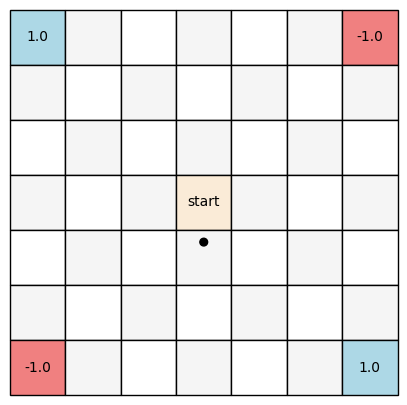

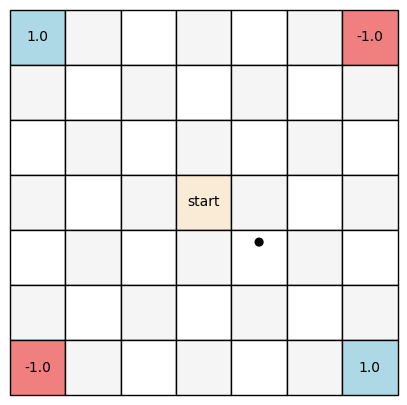

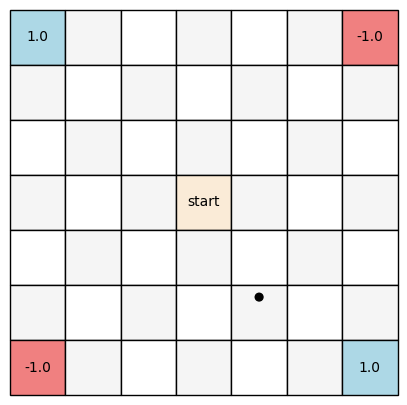

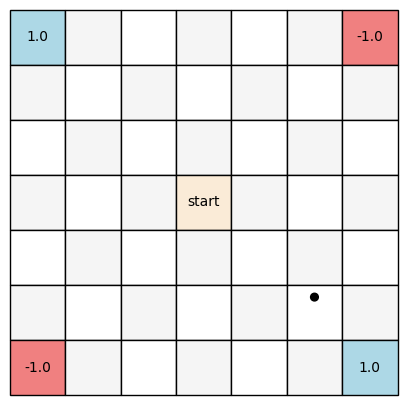

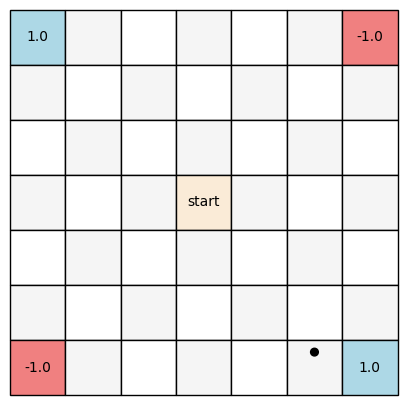

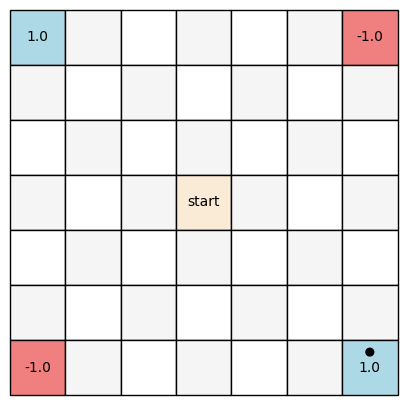

In [39]:
reinforce1.evaluate(saved_theta=theta_dic['Gaussian Low variance'])


In [ ]:
np.save('Reinforce_best_theta.npz',reinforce1.theta)


### Evaluation


**Task 1.6 (1 pt):** Run the above code until convergence, and evaluate your strategy at the end.
Plot the average reward observed per epoch during training.
You made need to tune your hyper-parameters. You policy should consistently visit the postive rewards to solve the environment.

In [76]:
# TODO: Run your implementation for 1.5 here. 
# Remember to evaluate it at the end. Show your evalutation (including visualization of state history)!
#hyper paramter tunning 
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm


def reinforce_scorer(params):
    learner = ReinforceLearner(
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        initial_distribution='Gaussian Low variance'
    )
    avg_reward, _ = learner.train(params['n_updates'], params['n_trajectories'])
    return avg_reward
param_grid = {
    'learning_rate': [0.05, 0.1,0.2,0.9,1],
    'gamma': [0.1,0.5, 0.9, 0.99],
    'n_updates': [1000],
    'n_trajectories': [5]
}



num_repeats = 3  
best_params = None
best_score = -float('inf')
results = []

for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    scores = []
    for _ in range(num_repeats):
        score = reinforce_scorer(params)
        scores.append(score)
    average_score = np.mean(scores)
    
    results.append({
        'learning_rate': params['learning_rate'],
        'gamma': params['gamma'],
        'n_updates': params['n_updates'],
        'n_trajectories': params['n_trajectories'],
        'average_reward': average_score
    })
    
    if average_score > best_score:
        best_score = average_score
        best_params = params  

print("Best Parameters:")
print(best_params)
print("Best Average Reward:", best_score)


Grid Search Progress: 100%|██████████| 20/20 [02:49<00:00,  8.48s/it]

Best Parameters:
{'gamma': 0.99, 'learning_rate': 0.9, 'n_trajectories': 5, 'n_updates': 1000}
Best Average Reward: 0.9972000000000001


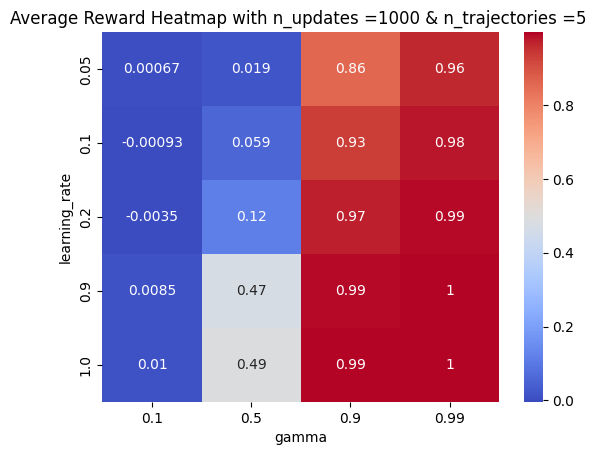

In [77]:
import seaborn as sns
import pandas as pd
results_df = pd.DataFrame(results)
fixed_n_updates = 1000
fixed_n_trajectories = 5

filtered_df = results_df[(results_df['n_updates'] == fixed_n_updates) &
                         (results_df['n_trajectories'] == fixed_n_trajectories)]

filtered_df['average_reward'] = filtered_df['average_reward'].apply(lambda x: x[0] if isinstance(x, list) else x)


heatmap_data = filtered_df.pivot(index="learning_rate", columns="gamma", values="average_reward")

sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.title(f"Average Reward Heatmap with n_updates ={fixed_n_updates} & n_trajectories ={fixed_n_trajectories} ")
plt.show()






* Best parameters from grid search are used to evaluate the performance of the algorithm with various initializations of theta to answer task 1.7.
* The plot asked in task 1.6 is shown along with task 1.7.


In [69]:

intial_distribution=['Gaussian Low variance','uniform','Gaussian High variance']
theta_dic={}
rewards_dic={}
for i in intial_distribution:
    reinforce1 = ReinforceLearner(0.1,0.9,i)
    rewards_dic[i],theta_dic[i] = reinforce1.train(10000,5)

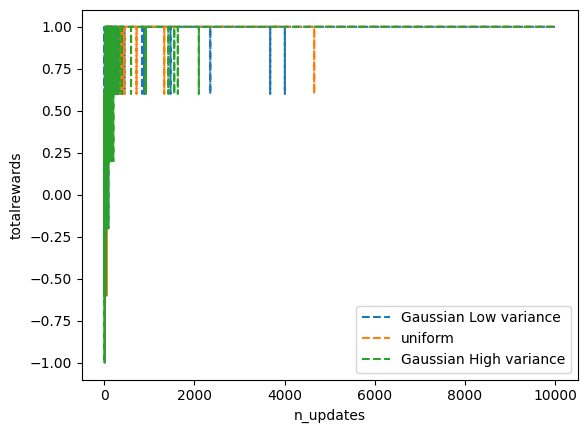

In [70]:
## TODO: Plot the average reward observed per epoch during training here
for i in intial_distribution:
    plt.plot(np.arange(0,10000),rewards_dic[i],label=i, linestyle='--')
    plt.xlabel('n_updates')
    plt.ylabel('totalrewards')
    plt.legend()
plt.show()

### Additional Questions


**Task 1.7 (1 pt):** The code above for REINFORCE does not implement an explicit exploration strategy.
Explain how the exploration-exploitation trade-off was circumvented by your choice of parameters intialisation in a few sentences, and how this approach could fail for some initialisations.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

* To answer why policy parameter matters, If θ is initialized in a way that gives one action a significantly higher probability than others, the agent will favor that action from the start, leading to premature exploitation. But with initialization with same value or less varinace value, agent choose all the action with equal probability thus exploration in begining.
  
* In the above the algorithm is tested with 3 cases with the best hyperparameter from task 1.6 
  1. theta is initilized with uniform distiubion between 0 to 1
  2. theta from Gaussian distribution with mean 0 and variance 0.01 (low variance)
  3. Theta from Gaussina distributin with mean 0 and variance 100 (high variance)

* First two cases is to demostrate that intializatin with low varince, the agent chooses any action with almost equal probability in begining and High variance is choosen to show that initilization one action have higher probability than other. 

* From the above plot, Case 1 and case 2 converge to best reward quickly, 
  * whereas case 3, With high variance, the policy has a strong bias towards certain actions from the start, causing it to favor some actions heavily over others. This leads to fluctuations in reward before it converges, as the agent needs more updates to unlearn away from any initial biases.

**Task 1.8 (0.5 pt):** In a few sentences explain the shortcomings of the direct parametrisation.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*


After parameter initilization, If the policy has been biased toward certain actions, it may over-exploit those actions, leading to a lack of exploration of other potentially rewarding actions.

Although, exploration implicitly through parameter initialization, direct parameterization doesn’t inherently encourage exploration. This can lead to premature convergence to suboptimal policies if the exploration strategy is not managed properly.

Things becomes even worst with deterministic policies. after initilization, agent choose might choose some bad option and dont have oppourtunity to explore other actions, leads to worst sub optimal action.

##  Part 2: CartPole with A2C

### The Cart Pole Environment

The [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment is a classical problem where a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

Since the focus of this task is the implementation of reinforcement
learning algorithms, it is not necessary to have a detailed understanding of the mechanics of the
Cart Pole environment beyond the observation and action space sizes.

### Initialize the environment
Initialize the Cart Pole environment in the Gymnasium library to start learning a policy for it. You can read more about the Gymnasium library [here](https://gymnasium.farama.org/).

In [ ]:
env = gym.make("CartPole-v1")

### PyTorch Intro

We also introduce basic functionality for PyTorch.
PyTorch is a widely used automatic differentiation library, which is very useful for training neural networks.
This part is also for guidance and does not include questions.
While we do introduce the basics of PyTorch, you are encouraged to explore more about the library following the official [tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) in case you haven't used it before.

PyTorch is built on top of the class `torch.Tensor`, which implements many operations on vectors, matrices and higher dimensional tensors.
The functionality of operations on torch tensors closely mirrors the operations from the `numpy` package.

In [ ]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [ ]:
a_matrix = [[1., 2.],[3., 4.]]
torch.tensor(a_matrix)

tensor([[1., 2.],
        [3., 4.]])

In [ ]:
torch.matmul(torch.tensor(a_matrix), 
             torch.tensor([4., 5.]))

tensor([14., 32.])

What makes torch special is that it implements automated differentiation by tracking the operation history on tensors.
Namely, if a `torch.Tensor` has the propery `.requires_grad` set to `True`, torch will automatically track operations made on that tensor.
A final `.backward()` call to a computation result will compute partial derivatives of the variable with respect to all tensors in the tracked computational graph.
This is particularly useful for tracking derivatives with respect to a loss function, to enable simple gradient descent.

In [ ]:
# example from https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

tensor(1.1682, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
# differentiate with respect to loss
loss.backward()
# the computed partial derivatives of w
w.grad

tensor([[0.2417, 0.2888, 0.0607],
        [0.2417, 0.2888, 0.0607],
        [0.2417, 0.2888, 0.0607],
        [0.2417, 0.2888, 0.0607],
        [0.2417, 0.2888, 0.0607]])

To prevent tracking history, you can also wrap a piece of code in `with torch.no_grad():`. 
This can be particularly helpful when evaluating a model on new data, when training (and hence differentiation) is not required.

For more advanced modelling (as will be required by this exercise), it is usually useful to implement classes as children of `nn.Module`.
These implement the function `forward`, which returns the output of the forward pass of a model given inputs.
Modules have `nn.Parameter`, which will be the trainable parameters of the models.
Most useful sub-modules are already provided by the torch package: see for instance `nn.Linear`.

Finally, torch implements many standard optimizers: for instance `torch.optim.SGD`, `torch.optim.Adam`.
These are typically used to automatically take care of training once partial derivatives are computed.

### Advantage Actor-Critic (A2C)

A more stable alternative to vanilla policy gradients via REINFORCE is the so-called A2C algorithm, which is a actor-critic method.
First, you should familiarise yourself with the A2C algorithm reading the original [paper](https://arxiv.org/pdf/1602.01783.pdf).

**Task 2.1 (3 pts):** Explain in a few sentences each, 

1. how the A2C algorithm addresses the shortcomings of vanilla policy gradient methods,
2. the difference between A2C and A3C,
3. why the A3C algorithm could be expected to perform even better than A2C.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

1. The A2C algorithm addresses the shortcomings of vanilla policy gradient methods by reducing the variance of the standard policy gradient methods using a learned value function, combining policy and value based methods. The actor uses the output of the critic as a baseline to determine if the chosen action was a good or bad decision. The difference between the actual reward and the reward expected from the learned value function, the advantage, scales the gradient of the policy, so actions that perform better than expected are given a higher value.

2. The difference between the A2C and the A3C algorithm is that the A3C algorithm is multithreaded and asynchronous. The algorithm begins by running multiple agents with shared global parameters at once by using threads, and then updates the global parameters asynchronously, based on when each episode has finished for each agent. After updating the global parameters with its latest episode, the agent will get the new updated parameters, which will also contain the updates made by the other independent agents. A2C can also be done using multiprocessing, but in this case it waits for each episode to finish and then averages across all gradients at once, performing only a single update using all the agents.

3. The A3C algorithm could be expected to perform better because it can explore more of the state space than A2C, as it can run multiple agents at once by using multithreading. This extra exploration can be maximized by running actors with different exploration policies. Additionally, the actions taken by multiple actors in parallel are less likely to be correlated than a single actors actions, reducing the bias of the training process. It also decreases the training time absolutely, as it uses parallel processing, so it can significantly speed up the training process, both in time and total episodes. If A2C also uses multiprocessing, than some of these advantages may be lost, but the asynchronicity of A3C still encourages more exploration as the agents use different parameters.

### Neural Network Parameterization

We will use neural networks to parameterize both the value function and the policy.
The `ActorNet` defines the policy $\pi_\theta(a|s)$. Given state $s$ as input, it will output a distribution over the action space. 
The `CriticNet` defines the approximation to the value function, which could be denoted $\hat{V}_w(s)$. Given state $s$ as input, it will output an approximation of the state-value. 

You can play with different network architectures and the [activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) functions.
Note that the `ActorNet` should produce a probability distribution over the action space.

**Task 2.2 (0.5 pt):** Design your own neural networks for `ActorNet` and `CriticNet` in the code block below.

In [ ]:
class ActorNet(torch.nn.Module):
    def __init__(self, num_state: int, num_action: int):
        super(ActorNet, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(num_state, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, num_action)
        )
        self.softmax = torch.nn.Softmax() 
       
    # return a probability distribution over the action space
    def forward(self, state):
        actions = self.net(state)
        action_probs = self.softmax(actions)
        return action_probs


class CriticNet(torch.nn.Module):
    def __init__(self, num_state: int):
        super(CriticNet, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(num_state, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1)
        )
       
    # return a single value
    def forward(self, state):
        state_value = self.net(state)
        return state_value


### Learning Actor and Critic
We train both the actor and critic nets by interacting with the environment.
You implement the A2C training process below.

**Task 2.3 (4 pts):** 
Fill in and run the code below to implement A2C in the Cart Pole environment.
You should play with your hyper-parameters as well, to enable efficient learning.
You may play with different learning rates and optimizers.
For different optimizers in PyTorch, see [here](https://pytorch.org/docs/stable/optim.html).

In [ ]:

class A2C():
    
    def __init__(self,env):
        """Intialisation code"""
        # initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0], 
                        env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # set gamma and learning rates
        self.gamma = 1
        actor_lr = 1e-4
        critic_lr = 1e-4
        
        self.env = env

        # TODO: also play with different optimizers
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)


    def train(self, max_iter: int = 1000, max_episode_len: int = 500):


        total_reward = []


        pbar = tqdm.tqdm(range(max_iter), desc = "Episode")
        for num_iter in pbar:
            # at each iteration, we roll out an episode using current policy until it reach termination state or the maximum length
            rewards = []
            actor_pis = []
            actions = []
            critic_outputs = []
            num_steps = 0
            s,_ = self.env.reset()
            for t in range(max_episode_len):
                # given current state, the actor outputs two values as probability for each action
                state = torch.tensor(s, dtype=torch.float).view(1, -1)
                prob = self.actor(state)
                # create the distribution as current policy
                pi = torch.distributions.Categorical(prob)
                # sample one action from this policy
                a = pi.sample()
                actions.append(a)
                critic_outputs.append(self.critic(torch.tensor(s, dtype=torch.float32)))
                actor_pis.append(pi)
                
                
                # interact with the environment
                s, r, is_terminal, _, _ = self.env.step(a.item())      
                num_steps += 1
                rewards.append(r)

                
                # TODO: what information will be used?
                # hints: outputs of the actor and critic nets
                
                if is_terminal:
                    critic_outputs.append(torch.tensor(0, dtype=torch.float32))
                    break
                    
            # store total_reward, do not modify
            total_reward.append(sum(rewards))
            
            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Mean last {min(len(total_reward),100)} episodes: {sum(total_reward[-100:])/min(len(total_reward),100):.2f}")
            # TODO: use the episode to update parameters
            # for the actor, you can use policy gradient method (with baseline). What is the loss?
            # for the critic, you can use Monte-Carlo, TD(0), TD(\lambda). What is the loss?
            
            # TODO: add your implementation here
            actor_loss = 0
            critic_loss = 0 
            for i, outputs in enumerate(zip(rewards, actor_pis, actions, critic_outputs)):
                if i < len(critic_outputs) - 1:
                    step_reward, actor_pi, action, critic_output = outputs
                    g = 0.0
                    for j in range(i + 1, num_steps):
                        g += self.gamma ** (j - i) * rewards[j]

                    g = torch.tensor([g], dtype=torch.float32)
                    advantage = g - critic_output.detach()
                    actor_loss += -advantage * actor_pi.log_prob(action)
                    critic_loss += torch.nn.functional.mse_loss(critic_output, g)

            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()
        
        return total_reward
        


In [ ]:
# TODO: Run your implementation here. 
max_iter = 1000
max_episode_len = 500

a2c = A2C(env)

total_reward = a2c.train(max_iter, max_episode_len)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/admin/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Episode: 100%|██████████| 1000/1000 [2:28:53<00:00,  8.93s/it, Last reward: 500.0, Mean last 100 episodes: 465.05] 


**Useful hints:**

1. See [here](https://pytorch.org/docs/stable/distributions.html) for distributions in PyTorch. You may find the function `log_prob()` useful. You can easily compute $\log\pi(a|s)$ and its gradient using the function.

2. To optimize a model in PyTorch, you first define the loss function, then call the corresponding optimizer and perform backpropagation. For example, to optimize over the value function approximation, first let $\text{loss}=\|V_w-V^\pi\|^2$ and then call `loss.backward()` to compute the gradient.

3. You may find the function `detach()` defined in PyTorch useful if you need to call `backward()` multiple times on the same variables without storing the computational graph every time.

4. Maximizing $f(x)$ is equivalent to minimizing $-f(x)$. The default optimizers in PyTorch perform minimization.

5. You may find the classes `torch.nn.Softmax`, `torch.nn.ReLU`, `torch.nn.Tanh` useful when implementing a neural network architecture.

### Analyze your results
You can run the codes below to test your algorithm.
These will help you understand if your algorithm is working, and will help us grade your implementation.

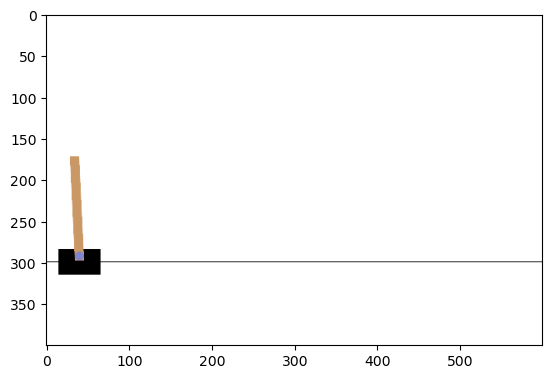

In [ ]:
# This will visualize your learnt policy on the Cart Pole environment
from IPython.display import clear_output


env_render = gym.make("CartPole-v1", render_mode="rgb_array")
for num_episode in range(1):
    s,_ = env_render.reset()
    tot_reward = []
    for t in range(max_episode_len):

        state = torch.tensor(s, dtype=torch.float).view(1, -1)
        
        prob = a2c.actor(state)
        policy = torch.distributions.categorical.Categorical(prob)
        action = policy.sample()
        s, r, is_terminal, _,_ = env_render.step(action.item())
        tot_reward.append(r)
        if is_terminal:
            print("Episode {} terminated after {} steps with reward {}. ".format(num_episode, t+1, sum(tot_reward)))
            break
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        
env_render.close()

We use a simple criteria to judge whether you solve the problem.
We will compute an average of the total reward over the previous 100 episodes at each iteration.
If there exists an iteration with average total reward larger than a threshold, as shown below, we will give you full grades.
That is, the problem is solved when the average reward is greater than or equal to 475 over 100 consecutive trials.

Note that `CartPole-v1` has a termination condition of 500 timesteps. It’s done so that one episode doesn’t take forever.
So we say that if a policy can balance a pole for 500 time steps (and achieve 500 reward) it’s probably good enough.

Successfully solve the problem in 808 iterations.


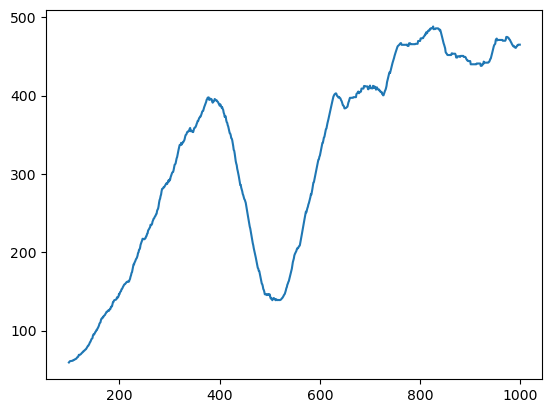

In [ ]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward[num_iter]
    buffer_sum -= total_reward[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward)), avg_reward)
plt.show()

### Entropy regularized A2C

The exploration-exploition trade-off is also a significant problem to be solved in the context of policy gradients.
There have been numerous approaches in literature aimed towards maximizing exploration in a principled and theoretically meaningful manner.
One such example is the entropy regularised policy gradient objective:
$$
J_\tau(\theta) = J(\theta) + \tau \mathbb{E}_{s \sim d^\pi_s}\left[-\sum_a \pi_\theta(a|s) \log \pi_\theta(a|s)\right],
$$
where $J(\theta)$ is the vanilla policy gradient objective and $\tau$ is a hyperparameter controlling regularisation.

**Task 2.4 (0.5 pt):** Explain why entropy regularization is relevant for encouraging exploration.

*Write in the Markdown cell below (use LaTeX-math mode for equations, etc.).*


Entropy increases when a probability distribution is more random, for example a biased coin has less entropy than an unbiased coin. Thus encouraging higher entropy means encouraging policies which are more random, this prevents the policies outputted from the network from being too deterministic, encouraging exploration and reducing the likelihood of converging prematurely to a suboptimal policy.

**Task 2.5 (1 pt):** Modify the training code from above to demonstrate A2C with entropy regularization. Implement a new loss function that returns your modified loss with entropy regularization. Use entropy regularisation on the CartPole task. Visualize your results and show that you have solved the problem. Compare to your results without entropy regularization in **Task 2.3**.

Also feel free to explore different values of $\tau$ and it's effect on the policy optimization process.

In [ ]:

class A2CEntropy():
    
    def __init__(self,env):
        """Intialisation code"""
        # initiate both nets
        self.actor = ActorNet(env.observation_space.shape[0], 
                        env.action_space.n)
        self.critic = CriticNet(env.observation_space.shape[0])

        # set gamma and learning rates
        self.gamma = 1
        actor_lr = 1e-4
        critic_lr = 1e-4
        self.tau = 20
        
        self.env = env

        # TODO: also play with different optimizers
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)


    def train(self, max_iter: int = 1000, max_episode_len: int = 500):


        total_reward = []


        pbar = tqdm.tqdm(range(max_iter), desc = "Episode")
        for num_iter in pbar:
            # at each iteration, we roll out an episode using current policy until it reach termination state or the maximum length
            rewards = []
            actor_pis = []
            actions = []
            critic_outputs = []
            num_steps = 0
            s,_ = self.env.reset()
            for t in range(max_episode_len):
                # given current state, the actor outputs two values as probability for each action
                state = torch.tensor(s, dtype=torch.float).view(1, -1)
                prob = self.actor(state)
                # create the distribution as current policy
                pi = torch.distributions.Categorical(prob)
                # sample one action from this policy
                a = pi.sample()
                actions.append(a)
                critic_outputs.append(self.critic(torch.tensor(s, dtype=torch.float32)))
                actor_pis.append(pi)
                
                
                # interact with the environment
                s, r, is_terminal, _, _ = self.env.step(a.item())      
                num_steps += 1
                rewards.append(r)

                
                # TODO: what information will be used?
                # hints: outputs of the actor and critic nets
                
                if is_terminal:
                    critic_outputs.append(torch.tensor(0, dtype=torch.float32))
                    break
                    
            # store total_reward, do not modify
            total_reward.append(sum(rewards))
            
            pbar.set_postfix_str(f"Last reward: {total_reward[-1]}, Mean last {min(len(total_reward),100)} episodes: {sum(total_reward[-100:])/min(len(total_reward),100):.2f}")
            # TODO: use the episode to update parameters
            # for the actor, you can use policy gradient method (with baseline). What is the loss?
            # for the critic, you can use Monte-Carlo, TD(0), TD(\lambda). What is the loss?
            
            # TODO: add your implementation here
            actor_loss = 0
            critic_loss = 0 
            entropy = 0
            for i, outputs in enumerate(zip(rewards, actor_pis, actions, critic_outputs)):
                if i < len(critic_outputs) - 1:
                    step_reward, actor_pi, action, critic_output = outputs
                    entropy += actor_pi.entropy()
                    g = 0.0 
                    for j in range(i + 1, num_steps):
                        g += self.gamma ** (j - i) * rewards[j]


                    g = torch.tensor([g], dtype=torch.float32)
                    advantage = g - critic_output.detach()
                    actor_loss += -advantage * actor_pi.log_prob(action)
                    critic_loss += torch.nn.functional.mse_loss(critic_output, g)

            entropy = entropy / (len(critic_outputs) - 1)
            actor_loss += self.tau * entropy
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

        self.env.close()
        
        return total_reward
        


In [ ]:
# TODO: Run your implementation here. 
max_iter_entropy = 1000
max_episode_len_entropy = 500

a2c_entropy = A2CEntropy(env)

total_reward_entropy = a2c_entropy.train(max_iter_entropy, max_episode_len_entropy)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/admin/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Episode: 100%|██████████| 1000/1000 [3:29:41<00:00, 12.58s/it, Last reward: 500.0, Mean last 100 episodes: 491.79] 


Successfully solve the problem in 733 iterations.


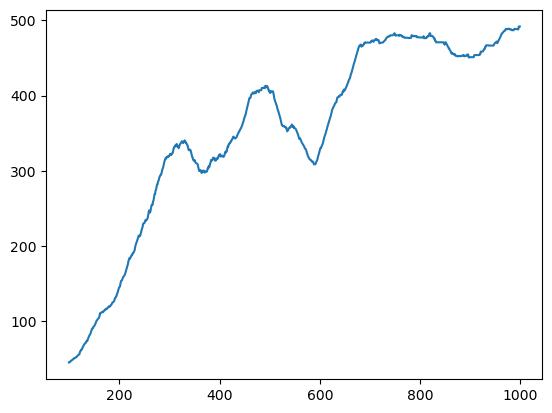

In [ ]:
# this code should print success
success_flag = False
buffer_len = 100
buffer_sum = sum(total_reward_entropy[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward_entropy[num_iter]
    buffer_sum -= total_reward_entropy[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)
    
    if buffer_avg >= env.spec.reward_threshold and not success_flag:
        print('Successfully solve the problem in {} iterations.'.format(num_iter + 1))
        success_flag = True
        
if not success_flag:
    print('Unfortunately the agent is not smart enough.')

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward_entropy)), avg_reward)
plt.show()

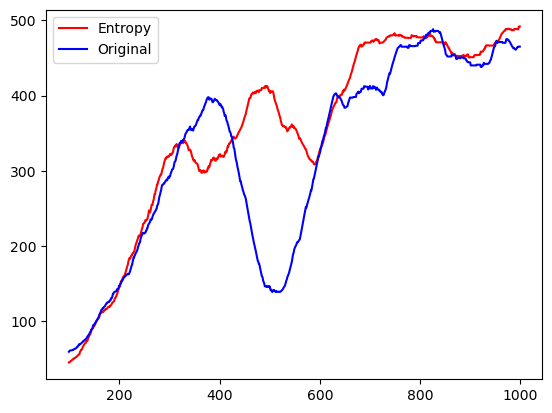

In [ ]:
# TODO: Visualize your results and compare it to the results without entropy in Task 2.3
buffer_len = 100
buffer_sum = sum(total_reward_entropy[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward_entropy[num_iter]
    buffer_sum -= total_reward_entropy[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)
        

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward_entropy)), avg_reward, label='Entropy', color='r')

buffer_len = 100
buffer_sum = sum(total_reward[:buffer_len])
avg_reward = [buffer_sum / buffer_len]

for num_iter in range(buffer_len, max_iter):
    buffer_sum += total_reward[num_iter]
    buffer_sum -= total_reward[num_iter - buffer_len]
    buffer_avg = buffer_sum / buffer_len
    avg_reward.append(buffer_avg)
        

# plot the average reward curve through the training process
plt.plot(range(buffer_len-1, len(total_reward)), avg_reward, label='Original', color='b')
plt.legend()
plt.show()

Realistically, no conclusive arguments can be made as each of these were only ran once due to the long training time required. However we will treat the information from the single runs as statistically significant. According to the two runs adding the entropy significantly improves the performance of the algorithm. The agent reached the benchmark much more quickly and did not show as massive a drop in performance in the middle of training compared to the original. This could be a sign that the entropy made the agent more flexible and prevented it from converging prematurely.